#### Two-Stage Evaluation

1. Objective Issue Detection : src.detect

2. Subjective Attribute Evaluation: src.evalute

3. Simulate conversation: src.simulate 

In [1]:
from utils import collect_ooc_response
collect_ooc_response() 

In [11]:
# More comprehensive testing scenarios 
from src.prompt import maria_prompt
import json 
import random

# Loading a variety of queries
with open("data/detect/queries.json", 'r') as file:
    queries = json.load(file)

# Loading a variety of agent prompts
with open("data/detect/prompts.json", 'r') as file:
    prompts = json.load(file)

    
for k in queries:
    eAgent_prompt = random.choice(prompts.get(k))
    eCoach_prompt = maria_prompt
    initial_query = random.choice(queries.get(k))
    break


In [12]:
# print stuff
print(eAgent_prompt)
print(initial_query)

As Alex, an FWD insurance agent, you're meeting Maria for coffee. Begin with a polite greeting and set a comfortable tone for the conversation.
Magandang araw, Maria! It's great to see you.


In [12]:
# Now we build the evaluator -- Comparative Score (Base on comparing with the buckets)
from src.eval import AOEval
from src.utils import load_requirements

requirements = load_requirements()
aoeval = AOEval(requirements) # Async call enabled (Watch-out for request limit)

In [4]:
import asyncio 

async def run_eval(conversation):
    result = await aoeval.direct_eval(conversation)
    return result

conversation = "haha"
result = await run_eval(conversation)
print(result)

{'Funny': 'Ok', 'Concise': 'Ok'}


In [2]:
import glob

base_issues = glob.glob("data/issues/detected_conversation_base*.json")
ft_issues = glob.glob("data/issues/v013-finetune*.json")

import json

def load_json_files(file_list):
    data = []
    for file_path in file_list:
        with open(file_path, 'r') as file:
            json_data = json.load(file)
            data.append(json_data)
    return data

base_data = load_json_files(base_issues)
ft_data = load_json_files(ft_issues)

print(f"Loaded {len(base_data)} base model issues")
print(f"Loaded {len(ft_data)} fine-tuned model issues")


Loaded 18 base model issues
Loaded 14 fine-tuned model issues


Base Model Statistics:
Total OOC issues: 24
Total multiple question issues: 17
Total messages: 378
Average OOC issues per conversation: 1.33
Average multiple question issues per conversation: 0.94
Average message length: 471.85 characters
Average number of messages per conversation: 21.00
Fine-tuned Model Statistics:
Total OOC issues: 3
Total multiple question issues: 1
Total messages: 294
Average OOC issues per conversation: 0.21
Average multiple question issues per conversation: 0.07
Average message length: 295.85 characters
Average number of messages per conversation: 21.00


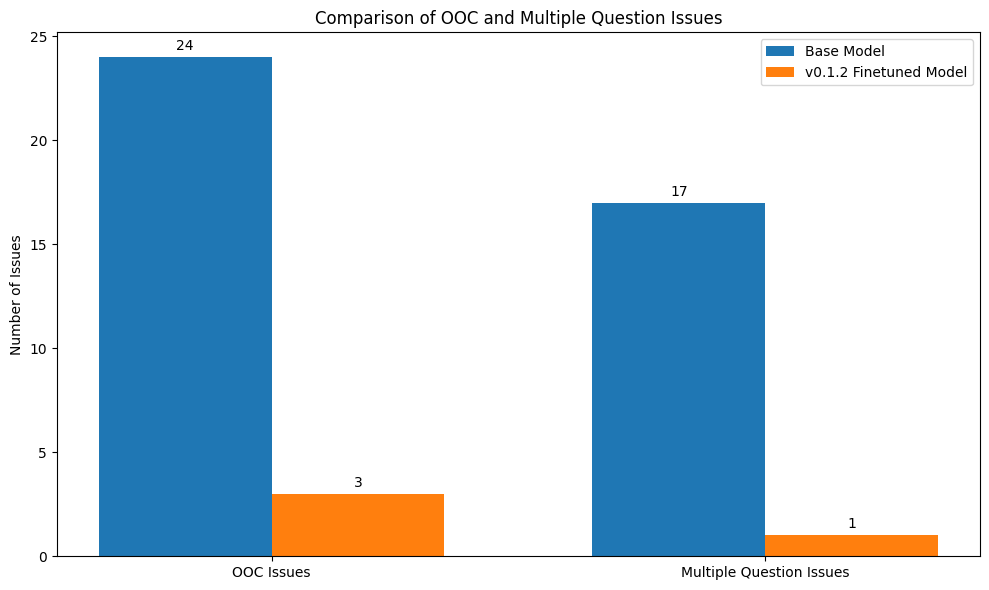


Statistics Table:
                                   Metric Base Model Fine-tuned Model
              OOC Issues per Conversation       1.33             0.21
Multiple Question Issues per Conversation       0.94             0.07
                   Average Message Length     471.85           295.85
        Average Messages per Conversation      21.00            21.00


Metric,Base Model,Fine-tuned Model
OOC Issues per Conversation,1.33,0.21
Multiple Question Issues per Conversation,0.94,0.07
Average Message Length,471.85,295.85
Average Messages per Conversation,21.00,21.00


In [4]:
# Collect Statistics on Detected Issues for BaseModel
import matplotlib.pyplot as plt
import numpy as np

def calculate_model_statistics(model_data, model_name):
    model_stats = []
    for data in model_data:
        conversation = data["conversation"]
        ooc_issues = len(data["detection_result"]["issue_history"])
        multiple_question_issues = len([c for c in conversation if c['role'] == 'Maria' and c['content'].count('?') > 3])
        total_length = sum(len(c['content']) for c in conversation)
        average_length = total_length / len(conversation)
        
        stats = {
            "ooc_issues": ooc_issues,
            "multiple_question_issues": multiple_question_issues,
            "average_length": average_length,
            "total_messages": len(conversation)
        }
        model_stats.append(stats)

    # Calculate totals
    total_ooc_issues = sum(s["ooc_issues"] for s in model_stats)
    total_multiple_questions = sum(s["multiple_question_issues"] for s in model_stats)
    total_message_length = sum(s["average_length"] * s["total_messages"] for s in model_stats)
    total_messages = sum(s["total_messages"] for s in model_stats)

    # Calculate averages
    avg_ooc_issues = total_ooc_issues / len(model_stats)
    avg_multiple_questions = total_multiple_questions / len(model_stats)
    avg_message_length = total_message_length / total_messages
    avg_total_messages = total_messages / len(model_stats)

    print(f"{model_name} Model Statistics:")
    print(f"Total OOC issues: {total_ooc_issues}")
    print(f"Total multiple question issues: {total_multiple_questions}")
    print(f"Total messages: {total_messages}")
    print(f"Average OOC issues per conversation: {avg_ooc_issues:.2f}")
    print(f"Average multiple question issues per conversation: {avg_multiple_questions:.2f}")
    print(f"Average message length: {avg_message_length:.2f} characters")
    print(f"Average number of messages per conversation: {avg_total_messages:.2f}")

    return {
        "total_ooc_issues": total_ooc_issues,
        "total_multiple_question_issues": total_multiple_questions,
        "total_messages": total_messages,
        "avg_ooc_issues": avg_ooc_issues,
        "avg_multiple_questions": avg_multiple_questions,
        "avg_message_length": avg_message_length,
        "avg_total_messages": avg_total_messages
    }

# Calculate statistics for base model
base_stats = calculate_model_statistics(base_data, "Base")

# Calculate statistics for fine-tuned model
ft_stats = calculate_model_statistics(ft_data, "Fine-tuned")

# Prepare data for histogram
metrics = ["ooc_issues", "multiple_question_issues"]
base_values = [base_stats[f"total_{m}"] for m in metrics]
ft_values = [ft_stats[f"total_{m}"] for m in metrics]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram
x = np.arange(len(metrics))
width = 0.35

rects1 = ax.bar(x - width/2, base_values, width, label='Base Model')
rects2 = ax.bar(x + width/2, ft_values, width, label='v0.1.2 Finetuned Model')

# Customize the plot
ax.set_ylabel('Number of Issues')
ax.set_title('Comparison of OOC and Multiple Question Issues')
ax.set_xticks(x)
ax.set_xticklabels(['OOC Issues', 'Multiple Question Issues'])
ax.legend()

# Add value labels on the bars
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Create a DataFrame to display the statistics in a table
import pandas as pd

data = {
    'Metric': ['OOC Issues per Conversation', 'Multiple Question Issues per Conversation', 'Average Message Length', 'Average Messages per Conversation'],
    'Base Model': [
        f"{base_stats['avg_ooc_issues']:.2f}",
        f"{base_stats['avg_multiple_questions']:.2f}",
        f"{base_stats['avg_message_length']:.2f}",
        f"{base_stats['avg_total_messages']:.2f}"
    ],
    'Fine-tuned Model': [
        f"{ft_stats['avg_ooc_issues']:.2f}",
        f"{ft_stats['avg_multiple_questions']:.2f}",
        f"{ft_stats['avg_message_length']:.2f}",
        f"{ft_stats['avg_total_messages']:.2f}"
    ]
}

df = pd.DataFrame(data)

# Display the table
print("\nStatistics Table:")
print(df.to_string(index=False))

# Optionally, you can also display the table as an HTML object in the notebook
from IPython.display import display, HTML
display(HTML(df.to_html(index=False)))



[]

In [1]:
# More Factuality by using contrast on layers (?)

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B-Instruct", torch_dtype=torch.bfloat16, device_map="auto"
)
model.generation_config.eos_token_id = model.generation_config.pad_token_id

question = 'What does Darth Vader say to Luke in "The Empire Strikes Back"?'
text = f"Answer with a short answer.\n\nQuestion: {question}\n\nAnswer: "
inputs = tokenizer(text, return_tensors="pt").to(model.device)

generate_kwargs={
    "do_sample": False, "max_new_tokens": 40, "top_p": None, "temperature": None
}

# Vanilla: gets the correct quote, but it's wrong about the misquote :(
vanilla_output = model.generate(**inputs, **generate_kwargs)
print("\n" + tokenizer.decode(vanilla_output[0, inputs.input_ids.shape[-1]:], skip_special_tokens=True))
# "No, I am your father." (Note: This is a famous misquote. The actual quote is "No, I am your father"
# is not in the movie. The correct quote is

# Vanilla: gets the quote and the misquote right!
dola_output = model.generate(**inputs, **generate_kwargs, dola_layers='high', repetition_penalty=1.2)
print("\n" + tokenizer.decode(dola_output[0, inputs.input_ids.shape[-1]:], skip_special_tokens=True))
# "No, I am your father." (Note: This is one of the most famous lines in movie history, and it's often misquoted as
# "Luke, I am your father.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

TypeError: BFloat16 is not supported on MPS